# CDO (Climate Data Operators)

https://code.mpimet.mpg.de/projects/cdo

https://pypi.org/project/cdo/

#### CDO is a collection of command line Operators to manipulate and analyse Climate model data. 

  - CDO has very small memory requirements and can process files larger than the physical memory.

  - More than 600 operators available.

  - Supported data formats are GRIB 1/2, netCDF 3/4, SERVICE, EXTRA and IEG. 
  
  - **Python bindings** enabling parallelization and integration with numpy/xarray/...
  
  -  Multiple types of return values:
     - output files, numpy arrays, masked arrays, XArray 
     - netCDF4 or XDataset handles
     - strings for operators, which write to stdout
     - None on error (optional)
     
   - Access to all options
     - `-f` file format
     - `-P` OpenMP-threads 
     - `...`


In [1]:
from cdo import Cdo
import intake
from os.path import expanduser
home = expanduser("~")

### CDO initialization

Before calling any operator, you have to create an object first:

In [2]:
cdo = Cdo()

### intake initialization

In [3]:
esm_file = home+"/data/CMIP6_ESM_colletion_file.json"
col = intake.open_esm_datastore(esm_file)

### Get datasets

In [4]:
query = dict( experiment_id="ssp585",
             source_id="EC-Earth3-Veg", 
             variable_id="tas",
             member_id="r1i1p1f1",
             table_id="Amon"
)
cat = col.search(**query)
ifiles = cat.df["path"].tolist()
ifiles

['/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp585/r1i1p1f1/Amon/tas/gr/v20200225/tas_Amon_EC-Earth3-Veg_ssp585_r1i1p1f1_gr_201501-201512.nc',
 '/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp585/r1i1p1f1/Amon/tas/gr/v20200225/tas_Amon_EC-Earth3-Veg_ssp585_r1i1p1f1_gr_201601-201612.nc',
 '/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp585/r1i1p1f1/Amon/tas/gr/v20200225/tas_Amon_EC-Earth3-Veg_ssp585_r1i1p1f1_gr_201701-201712.nc',
 '/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp585/r1i1p1f1/Amon/tas/gr/v20200225/tas_Amon_EC-Earth3-Veg_ssp585_r1i1p1f1_gr_201801-201812.nc',
 '/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp585/r1i1p1f1/Amon/tas/gr/v20200225/tas_Amon_EC-Earth3-Veg_ssp585_r1i1p1f1_gr_201901-201912.nc',
 '/home/jovyan/data/CMIP6/ScenarioMIP/EC-Earth-Consortium/EC-Earth3-Veg/ssp585/r1i1p1f1/Amon/tas/gr/v20200225/tas_Amon_EC-Earth3-Veg_ssp585_r1i1p

### File concatenation
Concatenate list of files into a temp file with relative time axis

In [5]:
concat_file = cdo.cat(input = ifiles, options = '-r')

### Get file information

In [6]:
cdo.infov(input=concat_file)

['-1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter name',
 '1 : 2015-01-16 12:00:00       2   131072       0 :      227.01      277.62      307.44 : tas',
 '2 : 2015-02-15 00:00:00       2   131072       0 :      233.21      277.87      307.38 : tas',
 '3 : 2015-03-16 12:00:00       2   131072       0 :      222.81      278.24      308.64 : tas',
 '4 : 2015-04-16 00:00:00       2   131072       0 :      218.12      279.00      308.45 : tas',
 '5 : 2015-05-16 12:00:00       2   131072       0 :      215.70      280.61      308.54 : tas',
 '6 : 2015-06-16 00:00:00       2   131072       0 :      217.44      282.33      313.59 : tas',
 '7 : 2015-07-16 12:00:00       2   131072       0 :      211.00      282.64      314.80 : tas',
 '8 : 2015-08-16 12:00:00       2   131072       0 :      208.90      282.29      314.74 : tas',
 '9 : 2015-09-16 00:00:00       2   131072       0 :      216.46      281.75      309.69 : tas',
 '10 : 2015-10-16 

### Basic data analysis

Compute the minimum over all input timesteps. If the `output` stream is omitted, a temporary file is written and its name is the return value of the call. Tempfiles are usually removed at the end of a script.

In [7]:
tminFile = cdo.timmin(input = concat_file)
tminFile

'/tmp/cdoPybx5f9wog'

In [8]:
cdo.infov(input=tminFile) 

['-1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter name',
 '1 : 2058-01-01 00:00:00       2   131072       0 :      208.90      270.34      300.65 : tas']

You can set an alternative directory for storing temporary files

In [9]:
cdo = Cdo(tempdir='/home/jovyan/work/EGI_Conf_2022/tmpdir')

Compute the maximum over all input timesteps

In [10]:
tmaxFile = cdo.timmax(input = concat_file)
tmaxFile

'/home/jovyan/work/EGI_Conf_2022/tmpdir/cdoPyp5w6mwn9'

### Store output data to a NetCDF file

Input and output files can be set with the `input` and `output` keywords.
In addition, command line options like `-f` can be used via the `options` keyword.

In [11]:
cdo.timmax(input = concat_file, output = "/home/jovyan/work/EGI_Conf_2022/cdo_max.nc",  options = '-f nc')

'/home/jovyan/work/EGI_Conf_2022/cdo_max.nc'

### Data access

When working with NetCDF, it is possible to get access to the data through a `file handle`, which offers the flexibility to go through the whole file with all its information like variables, dimensions and attributes. 

To get such a handle from a cdo call, use the `returnCdf` keyword when running a CDO operator

In [12]:
cdo.timmax(input = concat_file, returnCdf = True) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    CDI: Climate Data Interface version 2.0.5 (https://mpimet.mpg.de/cdi)
    Conventions: CF-1.7 CMIP-6.2
    source: EC-Earth3-Veg (2019): 
aerosol: none
atmos: IFS cy36r4 (TL255, linearly reduced Gaussian grid equivalent to 512 x 256 longitude/latitude; 91 levels; top level 0.01 hPa)
atmosChem: none
land: HTESSEL (land surface scheme built in IFS) and LPJ-GUESS v4
landIce: none
ocean: NEMO3.6 (ORCA1 tripolar primarily 1 degree with meridional refinement down to 1/3 degree in the tropics; 362 x 292 longitude/latitude; 75 levels; top grid cell 0-1 m)
ocnBgchem: none
seaIce: LIM3
    institution: AEMET, Spain; BSC, Spain; CNR-ISAC, Italy; DMI, Denmark; ENEA, Italy; FMI, Finland; Geomar, Germany; ICHEC, Ireland; ICTP, Italy; IDL, Portugal; IMAU, The Netherlands; IPMA, Portugal; KIT, Karlsruhe, Germany; KNMI, The Netherlands; Lund University, Sweden; Met Eireann, Ireland; NLeSC, The Neth

or use the `readCdf` method on a previously created temporary file

In [13]:
cdo.readCdf(tmaxFile)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version 2.0.5 (https://mpimet.mpg.de/cdi)
    source: EC-Earth3-Veg (2019): 
aerosol: none
atmos: IFS cy36r4 (TL255, linearly reduced Gaussian grid equivalent to 512 x 256 longitude/latitude; 91 levels; top level 0.01 hPa)
atmosChem: none
land: HTESSEL (land surface scheme built in IFS) and LPJ-GUESS v4
landIce: none
ocean: NEMO3.6 (ORCA1 tripolar primarily 1 degree with meridional refinement down to 1/3 degree in the tropics; 362 x 292 longitude/latitude; 75 levels; top grid cell 0-1 m)
ocnBgchem: none
seaIce: LIM3
    institution: AEMET, Spain; BSC, Spain; CNR-ISAC, Italy; DMI, Denmark; ENEA, Italy; FMI, Finland; Geomar, Germany; ICHEC, Ireland; ICTP, Italy; IDL, Portugal; IMAU, The Netherlands; IPMA, Portugal; KIT, Karlsruhe, Germany; KNMI, The Netherlands; Lund University, Sweden; Met Eireann, Ireland; NLeSC, The Netherlands; NTNU, Norway; Oxford University,

### Data Visualization: Plotting output with Matplotlib & Cartopy

Retrieve variable and dimensions values

In [14]:
data  = cdo.readCdf(tmaxFile)
tas = data.variables["tas"][:]
lat = data.variables["lat"][:]
lon = data.variables["lon"][:]

In [15]:
lat

masked_array(data=[-89.46282157, -88.76695135, -88.06697165, -87.36606343,
                   -86.66480301, -85.96337216, -85.26184606, -84.56026138,
                   -83.85863813, -83.15698813, -82.45531883, -81.75363514,
                   -81.05194045, -80.35023715, -79.64852699, -78.94681128,
                   -78.24509101, -77.54336694, -76.8416397 , -76.13990975,
                   -75.43817749, -74.73644324, -74.03470726, -73.33296977,
                   -72.63123095, -71.92949096, -71.22774993, -70.52600796,
                   -69.82426517, -69.12252163, -68.42077741, -67.71903259,
                   -67.01728721, -66.31554132, -65.61379497, -64.9120482 ,
                   -64.21030104, -63.50855352, -62.80680568, -62.10505753,
                   -61.40330909, -60.7015604 , -59.99981146, -59.2980623 ,
                   -58.59631292, -57.89456335, -57.19281359, -56.49106366,
                   -55.78931357, -55.08756333, -54.38581295, -53.68406242,
                   -52.98

Plot output on a map

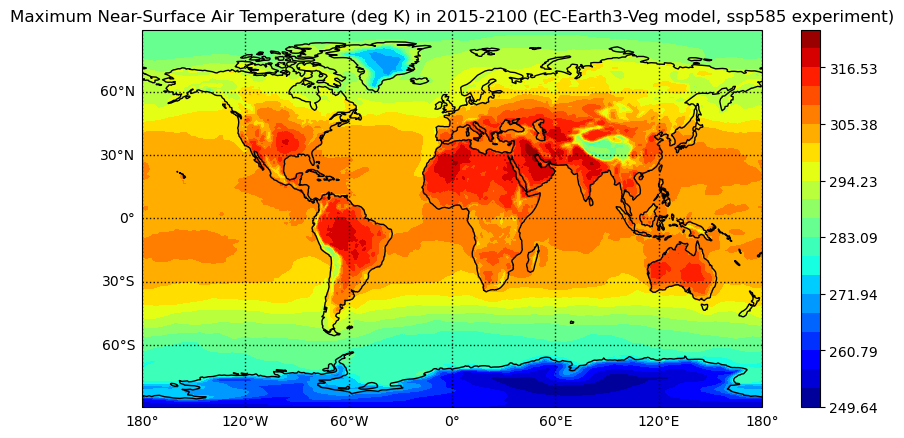

In [16]:
%matplotlib inline
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.util import add_cyclic_point
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import warnings
warnings.filterwarnings("ignore")
from os.path import expanduser
home = expanduser("~")

fig = plt.figure(figsize=(10, 5), dpi=100)

#Add Geo axes to the figure with the specified projection (PlateCarree)
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)

#Draw coastline and gridlines
ax.coastlines()

gl = ax.gridlines(crs=projection, draw_labels=True, linewidth=1, color='black', alpha=0.9, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False

tas = np.reshape(tas, (len(lat), len(lon)))

#Wraparound points in longitude
var_cyclic, lon_cyclic = add_cyclic_point(tas, coord=np.asarray(lon))
x, y = np.meshgrid(lon_cyclic,lat)

#Define color levels for color bar
levStep = (np.nanmax(tas)-np.nanmin(tas))/20
clevs = np.arange(np.nanmin(tas),np.nanmax(tas)+levStep,levStep)

#Set filled contour plot
cnplot = ax.contourf(x, y, var_cyclic, clevs,transform=projection, cmap=plt.cm.jet)  # transform keyword provided
plt.colorbar(cnplot,ax=ax)

ax.set_aspect('auto', adjustable=None)

plt.title('Maximum Near-Surface Air Temperature (deg K) in 2015-2100 (EC-Earth3-Veg model, ssp585 experiment)')
plt.show()